In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgb
import networkx as nx
from collections import Counter
from matplotlib import ticker
from scipy.sparse import hstack 

unTPath = "../../../../../unT/ffunes/"
figuresPath = unTPath + "figures/"

%matplotlib inline

sns.set_theme()

In [2]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [2]:
try:
    conn = psycopg2.connect(user = "ffunes",
                            password = "location8",
                            host = "127.0.0.1",
                            port = "5432",
                            database = "elecciones_twitter")
except:
    print("No se pudo conectar a la base de datos")

In [4]:
follows = pd.read_sql_query(
    'SELECT *\
    FROM followers\
    WHERE follower_id IN (SELECT id FROM users_location_exact)\
    OR\
    followee_id in (SELECT id FROM users_location_exact)'
    ,con=conn
)

In [5]:
follows

,follower_id,followee_id
0,442283723,267110606
1,442283723,2200550785
2,442283723,434471575
3,442283723,17716224
4,442283723,18036284
...,...,...
5903435,68868337,62176808
5903436,68868337,136773304
5903437,68868337,25119832
5903438,442283723,20723512


In [6]:
follows.to_csv(unTPath + 'exact/follows_exact.csv')

# Análisis básico

In [6]:
usecols = [
    "follower_id",
    "followee_id"
]

follows = pd.read_csv(unTPath + 'exact/follows_exact.csv', usecols=usecols)

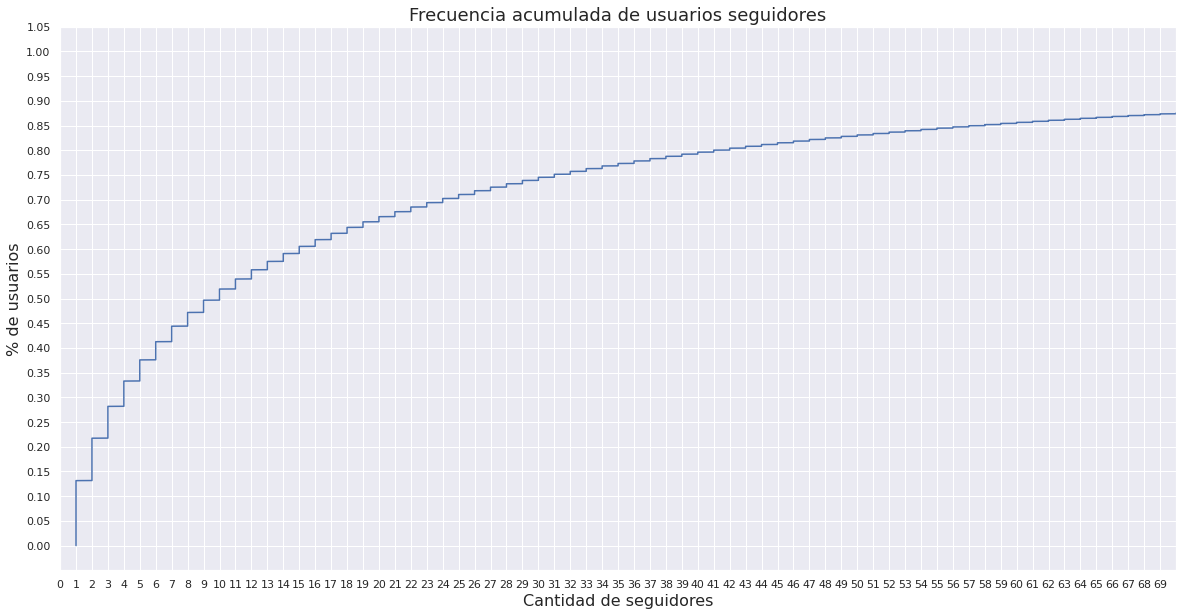

In [7]:
unique_followers = follows.groupby('followee_id').count()

ecdf = ECDF(unique_followers["follower_id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de seguidores", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios seguidores", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

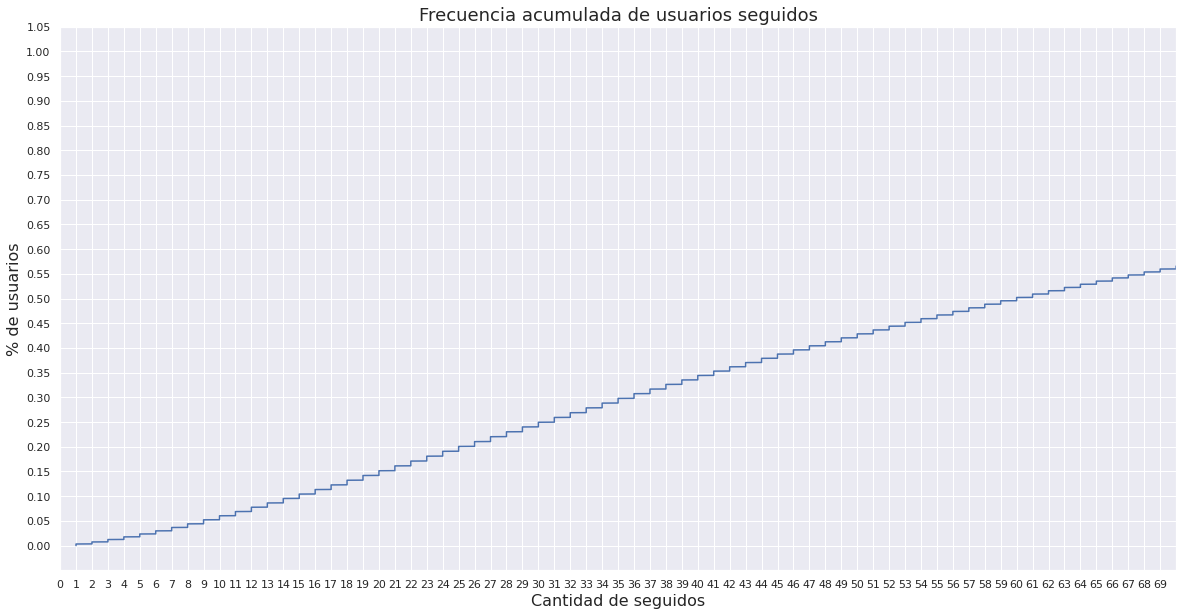

In [8]:
unique_followers = follows.groupby('follower_id').count()

ecdf = ECDF(unique_followers["followee_id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de seguidos", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios seguidos", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [3]:
def filter_users_with_follows(min_followers=None, max_followers=None):
    # Cargamos usuarios con seguidos
    usecols = [
        "follower_id",
        "followee_id"
    ]
    
    follows = pd.read_csv(unTPath + 'exact/follows_exact.csv', usecols=usecols)
    users = pd.read_pickle(unTPath + 'exact/users_exact_coords.pkl')
    
    followers_count = follows.groupby('followee_id').count().reset_index()
    
    min_followers = 1 if min_followers == None else min_followers
        
    if max_followers != None:
        lim_followers = followers_count.loc[
            ((followers_count["follower_id"] >= min_followers) & (followers_count["follower_id"] <= max_followers)),
            ["followee_id"]
        ]
    else:
        lim_followers = followers_count.loc[
            (followers_count["follower_id"] >= min_followers),
            ["followee_id"]
        ]
    
    follows_a = pd.merge(
        left=follows,
        right=lim_followers,
        how='inner',
        left_on='followee_id',
        right_on='followee_id',
        validate='m:1'
    )
    
    follows_list = follows_a.groupby(["follower_id"])["followee_id"].apply(list).reset_index(name="users_followed")
    
    follows_b_list = follows.groupby(["followee_id"])["follower_id"].apply(list).reset_index(name="users_followers")

    users_with_followees = pd.merge(
        left=users,
        right=follows_list,
        how='left',
        left_on=["id"],
        right_on=["follower_id"],
        validate="1:1" 
    )
    
    del users_with_followees["follower_id"]
    
    users_with_followees = pd.merge(
        left=users_with_followees,
        right=follows_b_list,
        how='left',
        left_on=["id"],
        right_on=["followee_id"],
        validate="1:1" 
    )
    
    del users_with_followees["followee_id"]
        
    print(
        "Totalidad de usuarios", users.shape[0],
        "\nUsuarios totales que siguen", users_with_followees.dropna(subset=["users_followed"]).shape[0],
    )
    
    return users_with_followees

In [4]:
users_with_follows = filter_users_with_follows(None, None)
users_with_follows.shape

Totalidad de usuarios 37146 
Usuarios totales que siguen 20262


(37146, 23)

In [5]:
users_with_follows.loc[users_with_follows['users_followers'].isnull(), ['users_followers']] = users_with_follows.loc[users_with_follows['users_followers'].isnull(),'users_followers'].apply(lambda x: [])
users_with_follows.loc[users_with_follows['users_followed'].isnull(), ['users_followed']] = users_with_follows.loc[users_with_follows['users_followed'].isnull(),'users_followed'].apply(lambda x: [])

In [6]:
graph_follows = nx.DiGraph()

In [7]:
graph_follows.add_nodes_from(users_with_follows["id"].to_numpy())

In [8]:
for user_id, users_followed in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followed"].to_numpy()):
    graph_follows.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followers"].to_numpy()):
    graph_follows.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [9]:
print("Nodos: ", len(graph_follows.nodes), "Aristas: ", len(graph_follows.edges))

Nodos:  686694 Aristas:  5903440


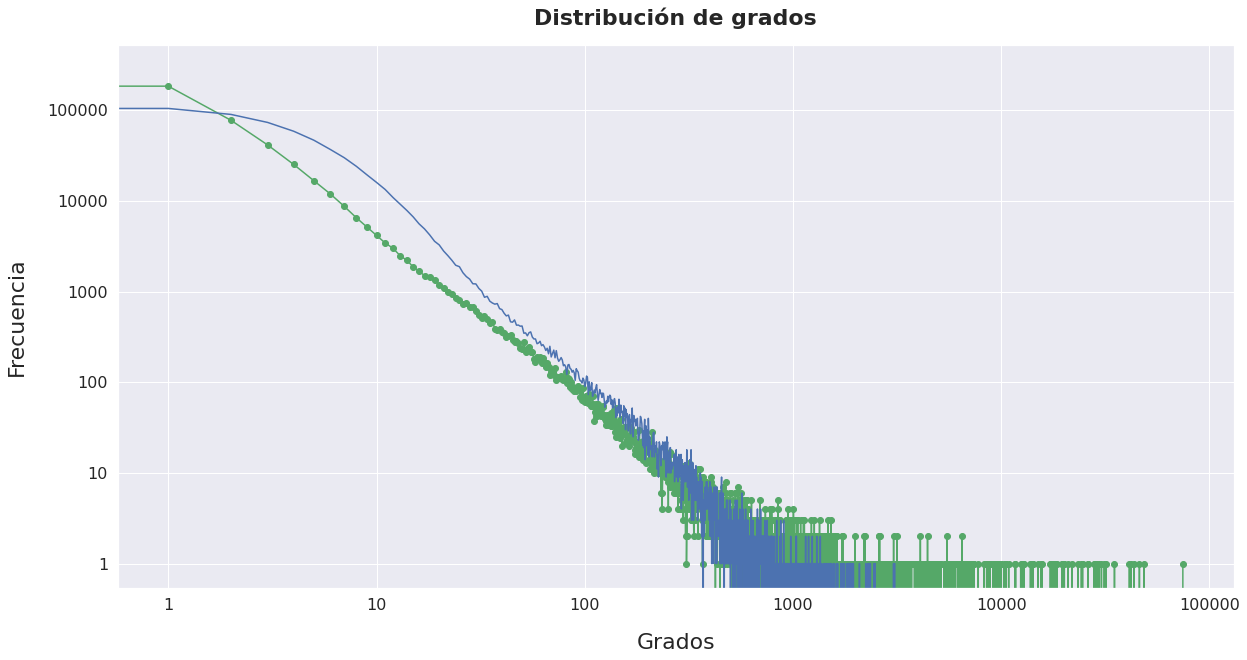

In [33]:
in_degree_freq = degree_histogram_directed(graph_follows, in_degree=True)
out_degree_freq = degree_histogram_directed(graph_follows, out_degree=True)

degrees_in = range(len(in_degree_freq))
degrees_out = range(len(out_degree_freq))

f, ax = plt.subplots(figsize=(20, 10))

plt.loglog(degrees_in, in_degree_freq, 'go-', label='in-degree') 
plt.loglog(degrees_out, out_degree_freq, '-', label='out-degree') 

ax.set_title("Distribución de grados", fontweight='bold', fontsize=22, pad=20)
ax.set_xlabel('Grados', fontsize=22, labelpad=20)
ax.set_ylabel('Frecuencia', fontsize=22, labelpad=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

#f.savefig(figuresPath + 'follows/distribucion_grados_entrantes.pdf', bbox_inches = 'tight')

plt.show()

In [10]:
users_ids = users_with_follows["id"].to_numpy()

set_users = set(users_ids)

for x in users_with_follows["users_followed"].to_numpy():
    set_users |= set(x)
    
for x in users_with_follows["users_followers"].to_numpy():
    set_users |= set(x)
    
follows_users = list(set_users.difference(set(users_ids)))

total_users_follows = list(users_ids) + follows_users
len(total_users_follows)

686694

In [11]:
vector_of_follows = nx.adjacency_matrix(graph_follows, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows

<686694x686694 sparse matrix of type '<class 'numpy.uint8'>'
	with 5903440 stored elements in Compressed Sparse Row format>

In [12]:
vector_of_follows_compl = vector_of_follows[0:len(users_ids), 0:len(users_ids)]
vector_of_follows_compl

<37146x37146 sparse matrix of type '<class 'numpy.uint8'>'
	with 164376 stored elements in Compressed Sparse Row format>

In [9]:
users_with_follows = filter_users_with_follows(None, 20)
users_with_follows.shape

Totalidad de usuarios 37146 
Usuarios totales que siguen 20063


(37146, 20)

In [17]:
users_with_follows.loc[users_with_follows['users_followers'].isnull(), ['users_followers']] = users_with_follows.loc[users_with_follows['users_followers'].isnull(),'users_followers'].apply(lambda x: [])
users_with_follows.loc[users_with_follows['users_followed'].isnull(), ['users_followed']] = users_with_follows.loc[users_with_follows['users_followed'].isnull(),'users_followed'].apply(lambda x: [])

In [18]:
users_ids = users_with_follows["id"].to_numpy()

set_users = set(users_ids)

for x in users_with_follows["users_followed"].to_numpy():
    set_users |= set(x)
    
for x in users_with_follows["users_followers"].to_numpy():
    set_users |= set(x)
    
follows_users = list(set_users.difference(set(users_ids)))

total_users_follows = list(users_ids) + follows_users
len(total_users_follows)

711200

In [10]:
#users_with_follows.to_pickle(unTPath + 'exact/users_exact_followers.pkl')

In [37]:
graph_follows_collapsed = nx.Graph()

graph_follows_collapsed.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followed"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followers"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [38]:
vector_of_follows_local = nx.adjacency_matrix(graph_follows_collapsed, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows_local = vector_of_follows_local[0:len(users_ids), 0:len(users_ids)]
vector_of_follows_local

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 340696 stored elements in Compressed Sparse Row format>

In [39]:
graph_follows_collapsed = nx.DiGraph()

graph_follows_collapsed.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followed"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followers"].to_numpy()):
    graph_follows_collapsed.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [40]:
vector_of_follows = nx.adjacency_matrix(graph_follows_collapsed, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows = vector_of_follows.astype(np.bool).astype(np.uint8)
vector_of_follows.eliminate_zeros()
vector_of_follows

<711200x711200 sparse matrix of type '<class 'numpy.uint8'>'
	with 5095407 stored elements in Compressed Sparse Row format>

In [41]:
vector_of_ac_follows = vector_of_follows[0:len(users_ids), :]
vector_of_ac_follows

<43567x711200 sparse matrix of type '<class 'numpy.uint8'>'
	with 1303004 stored elements in Compressed Sparse Row format>

In [42]:
m_vector_of_follows = vector_of_follows_local.copy()
m_vector_of_follows[m_vector_of_follows > 0] = 0
m_vector_of_follows.eliminate_zeros()
m_vector_of_follows = hstack([m_vector_of_follows, vector_of_ac_follows[:, len(users_ids):]])
# Convertimos a bool para que los pesos de las aristas pasen a ser todos 1
m_vector_of_follows = m_vector_of_follows.astype(bool).astype(np.uint8).tocsr()
m_vector_of_follows

<43567x711200 sparse matrix of type '<class 'numpy.uint8'>'
	with 1105234 stored elements in Compressed Sparse Row format>

In [43]:
m_vector_of_co_follows = m_vector_of_follows.dot(m_vector_of_follows.T)
m_vector_of_co_follows.setdiag(0, k=0)
m_vector_of_co_follows.eliminate_zeros()
m_vector_of_co_follows

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 3110890 stored elements in Compressed Sparse Row format>

In [44]:
vector_of_col_follows = vector_of_follows_local + m_vector_of_co_follows
#vector_of_col_mentions.setdiag(0, k=0)
vector_of_col_follows.eliminate_zeros()
vector_of_col_follows

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 3333058 stored elements in Compressed Sparse Row format>

In [228]:
users_with_follows = filter_users_with_follows(None, 5)
users_with_follows.shape

Totalidad de usuarios 43567 
Usuarios totales que siguen 23100


(43567, 20)

In [229]:
users_with_follows.loc[users_with_follows['users_followers'].isnull(), ['users_followers']] = users_with_follows.loc[users_with_follows['users_followers'].isnull(),'users_followers'].apply(lambda x: [])
users_with_follows.loc[users_with_follows['users_followed'].isnull(), ['users_followed']] = users_with_follows.loc[users_with_follows['users_followed'].isnull(),'users_followed'].apply(lambda x: [])

In [230]:
users_ids = users_with_follows["id"].to_numpy()

set_users = set(users_ids)

for x in users_with_follows["users_followed"].to_numpy():
    set_users |= set(x)
    
for x in users_with_follows["users_followers"].to_numpy():
    set_users |= set(x)
    
follows_users = list(set_users.difference(set(users_ids)))

total_users_follows = list(users_ids) + follows_users
len(total_users_follows)

708294

In [231]:
graph_cofollows = nx.DiGraph()

graph_cofollows.add_nodes_from(users_ids)

for user_id, users_followed in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followed"].to_numpy()):
    graph_cofollows.add_edges_from(list(map(lambda x: (user_id, x), users_followed)))
    
for user_id, users_follower in zip(users_with_follows["id"].to_numpy(), users_with_follows["users_followers"].to_numpy()):
    graph_cofollows.add_edges_from(list(map(lambda x: (x, user_id), users_follower)))

In [236]:
vector_of_follows = nx.adjacency_matrix(graph_cofollows, nodelist=total_users_follows).astype(np.uint8)
vector_of_follows = vector_of_follows.astype(np.bool).astype(np.uint8)[0:len(users_ids), :]
#vector_of_follows.eliminate_zeros()
vector_of_follows.setdiag(1, k=0)
vector_of_follows

<43567x708294 sparse matrix of type '<class 'numpy.uint8'>'
	with 873635 stored elements in Compressed Sparse Row format>

In [237]:
vector_of_follows[0:len(users_ids), 0:len(users_ids)]

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 241337 stored elements in Compressed Sparse Row format>

In [238]:
vector_of_follows.eliminate_zeros()
vector_of_follows

<43567x708294 sparse matrix of type '<class 'numpy.uint8'>'
	with 873635 stored elements in Compressed Sparse Row format>

In [239]:
vector_of_co_follows = vector_of_follows.dot(vector_of_follows.T)
vector_of_co_follows.setdiag(0, k=0)
vector_of_co_follows.eliminate_zeros()
vector_of_co_follows

<43567x43567 sparse matrix of type '<class 'numpy.uint8'>'
	with 49476706 stored elements in Compressed Sparse Row format>